In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV

from  utils import load_credit_card_data, load_hotel_booking_data, learning_Curve, plot_learning_curve, plot_learning_curve_time, compare_fit_time, compare_pred_time, compare_learn_time

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])

# 1. Load Data

## 1.1 Load credit card fraud data

In [3]:
X_credit, y_credit = load_credit_card_data("../data/creditcard.csv", sample_rate=0.2)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split (X_credit, y_credit, test_size = 0.3, random_state = 0)


In [4]:
y_credit.Class.value_counts()

0    56860
1      101
Name: Class, dtype: int64

## 1.2 Load hotel booking data

In [5]:
# load hotel booking data
X_hotel, y_hotel = load_hotel_booking_data("../data/hotel_bookings.csv", sample_rate=0.2)
X_hotel_train, X_hotel_test, y_hotel_train, y_hotel_test = train_test_split(X_hotel, y_hotel, test_size=0.3, random_state=0)

In [6]:
y_hotel['is_canceled'].value_counts()

0    14934
1     8944
Name: is_canceled, dtype: int64

# 2. Supervied Models

## 2.1 Decicison Tree

In [7]:
def dt_model_complexity (X_train, y_train, X_test, y_test, title):
    f1_score_test = []
    f1_score_train = []

    max_depth = list(range(1,31))
    for i in max_depth:
        dtc = DecisionTreeClassifier(max_depth=i, random_state=1, min_samples_leaf=1, criterion='entropy')
        dtc.fit(X_train, y_train)
        y_train_pred = dtc.predict(X_train)
        y_test_pred = dtc.predict(X_test)
        
        f1_score_train.append(f1_score(y_train, y_train_pred))
        f1_score_test.append(f1_score(y_test, y_test_pred))

    # print(f1_score_test)
    # print(f1_score_train)

    plt.plot(max_depth, f1_score_train, "r-+", linewidth=2, label='Training F1 score')
    plt.plot(max_depth, f1_score_test, "b-+", linewidth=2, label='Testing F1 score')
    plt.ylabel('Model F1 score')
    plt.xlabel('Max Tree depth')
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.title(title)
    plt.show()


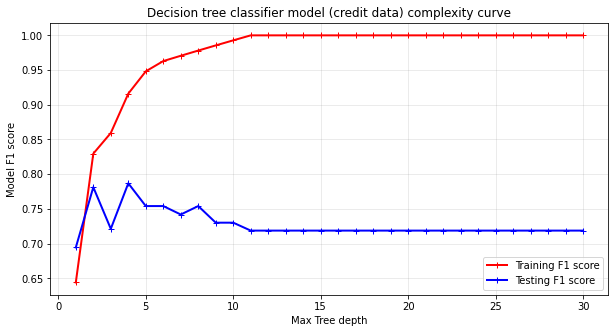

In [32]:
dt_model_complexity(X_credit_train, y_credit_train, X_credit_test, y_credit_test,'Decision tree classifier model (credit data) complexity curve')

In [7]:
%%time
# tuning parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.001, 0.004, 0.008, 0.01]
}

search_credit_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_credit_dt.fit(X_credit_train, y_credit_train)
y_credit_pred = search_credit_dt.predict(X_credit_test)

accuracy_credit = accuracy_score(y_credit_test, y_credit_pred)
print("===========================================")
print("Classification Report for Credit Card Fraud")
print(accuracy_credit)
print(classification_report(y_credit_test, y_credit_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.4s finished
Classification Report for Credit Card Fraud
0.9987711393293932
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.66      0.68      0.67        31

    accuracy                           1.00     17089
   macro avg       0.83      0.84      0.83     17089
weighted avg       1.00      1.00      1.00     17089

CPU times: user 2.12 s, sys: 201 ms, total: 2.32 s
Wall time: 14.1 s


In [8]:
%%time

search_hotel_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_hotel_dt.fit(X_hotel_train, y_hotel_train)
y_hotel_pred = search_hotel_dt.predict(X_hotel_test)

accuracy_hotel = accuracy_score(y_hotel_test, y_hotel_pred)
print("===========================================")
print("Classification Report for Hotel Booking Cancellation")
print(accuracy_hotel)
print(classification_report(y_hotel_test, y_hotel_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished
Classification Report for Hotel Booking Cancellation
0.9553322166387493
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4469
           1       0.96      0.92      0.94      2695

    accuracy                           0.96      7164
   macro avg       0.96      0.95      0.95      7164
weighted avg       0.96      0.96      0.96      7164

CPU times: user 758 ms, sys: 42.8 ms, total: 800 ms
Wall time: 1.76 s


In [11]:
train_credit_dt_metric, val_credit_dt_metric, indices_credit_dt, training_credit_dt_time, testing_credit_dt_time = learning_Curve(X_credit_train, y_credit_train, X_credit_test, y_credit_test, search_credit_dt.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.023090839385986328
training 4000 samples took 0.04465007781982422
training 6000 samples took 0.057935237884521484
training 8000 samples took 0.07977104187011719
training 10000 samples took 0.15996813774108887
training 12000 samples took 0.2264268398284912
training 14000 samples took 0.3063390254974365
training 16000 samples took 0.38611698150634766
training 18000 samples took 0.49680471420288086
training 20000 samples took 0.5377421379089355
training 22000 samples took 0.6925680637359619
training 24000 samples took 0.767845869064331
training 26000 samples took 1.0928871631622314
training 28000 samples took 1.0738811492919922
training 30000 samples took 1.1558330059051514
training 32000 samples took 1.2545831203460693
training 34000 samples took 1.2234129905700684
training 36000 samples took 1.391645908355713
training 38000 samples took 1.3998620510101318


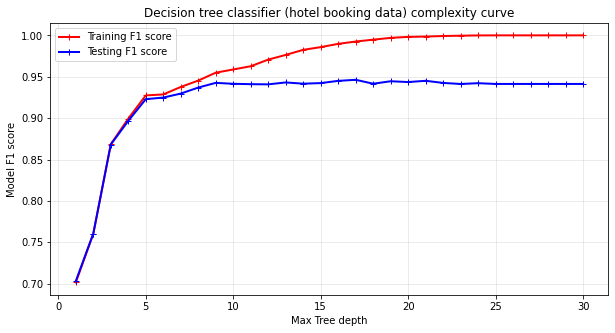

In [33]:
dt_model_complexity(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test,'Decision tree classifier (hotel booking data) complexity curve')

In [10]:
train_hotel_dt_metric, val_hotel_dt_metric, indices_hotel_dt, training_hotel_dt_time, testing_hotel_dt_time = learning_Curve(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, search_hotel_dt.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.020194053649902344
training 4000 samples took 0.023622989654541016
training 6000 samples took 0.03477191925048828
training 8000 samples took 0.04063725471496582
training 10000 samples took 0.060254812240600586
training 12000 samples took 0.06413507461547852
training 14000 samples took 0.07164859771728516
training 16000 samples took 0.08223700523376465


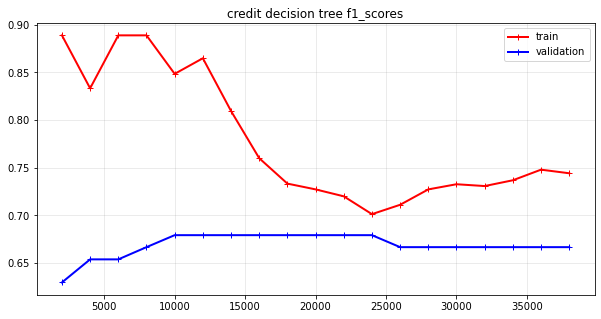

In [13]:
plot_learning_curve(train_credit_dt_metric, val_credit_dt_metric, indices_credit_dt, title="credit decision tree f1_scores")

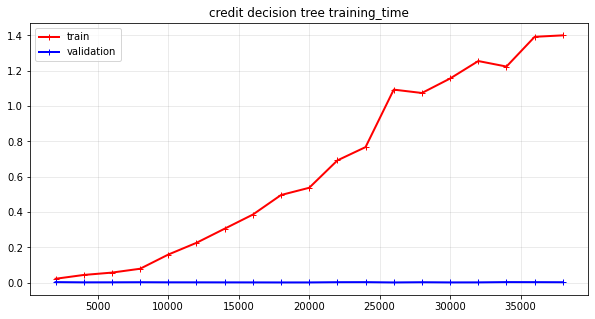

In [15]:
plot_learning_curve(training_credit_dt_time, testing_credit_dt_time, indices_credit_dt, title="credit decision tree training_time")

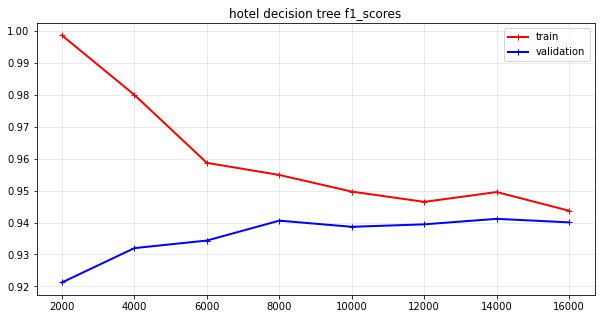

In [16]:
plot_learning_curve(train_hotel_dt_metric, val_hotel_dt_metric, indices_hotel_dt, title="hotel decision tree f1_scores")

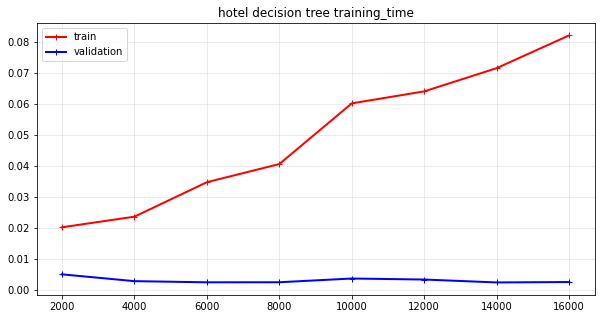

In [17]:
plot_learning_curve(training_hotel_dt_time, testing_hotel_dt_time, indices_hotel_dt, title="hotel decision tree training_time")

## 2.2 Neural Network

In [60]:
%%time
param_grid = {
    'hidden_layer_sizes': [(16, 16), (16, 32), (32, 32), (32, 64), (64, 64), (64, 128)],
    "alpha" : [0.1, 0.001, 0.0001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
search_credit_mlp = GridSearchCV(MLPClassifier(max_iter=500, random_state=128), param_grid, cv=5, n_jobs=-1, verbose=3)
search_credit_mlp.fit(X_credit_train, y_credit_train)

y_credit_pred = search_credit_mlp.predict(X_credit_test)

accuracy_credit = accuracy_score(y_credit_test, y_credit_pred)
print("===========================================")
print("Classification Report for Credit Card Fraud")
print(accuracy_credit)
print(classification_report(y_credit_test, y_credit_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.3min finished
/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Classification Report for Credit Card Fraud
0.9992392767277196
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.82      0.74      0.78        31

    accuracy                           1.00     17089
   macro avg       0.91      0.87      0.89     17089
weighted avg       1.00      1.00      1.00     17089

CPU times: user 1min, sys: 629 ms, total: 1min
Wall time: 3min 24s


In [99]:
%%time
param_grid = {
    'hidden_layer_sizes': [(16, 16), (32, 32), (32, 64), (32, 128), (32, 256), (16, 16, 32), (16, 32, 64)],
    "alpha" : [0.1, 0.001, 0.0001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
search_hotel_mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=128), param_grid, cv=8, n_jobs=-1, verbose=3)
search_hotel_mlp.fit(X_hotel_train, y_hotel_train)

y_hotel_pred = search_hotel_mlp.predict(X_hotel_test)

accuracy_hotel = accuracy_score(y_hotel_test, y_hotel_pred)
print("===========================================")
print("Classification Report for Hotel Booking Cancellation")
print(accuracy_hotel)
print(classification_report(y_hotel_test, y_hotel_pred))
print(search_hotel_mlp.best_estimator_)

Fitting 8 folds for each of 63 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  5.3min finished


Classification Report for Hotel Booking Cancellation
0.696677833612507
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      4469
           1       0.65      0.42      0.51      2695

    accuracy                           0.70      7164
   macro avg       0.68      0.64      0.65      7164
weighted avg       0.69      0.70      0.68      7164

MLPClassifier(alpha=0.001, hidden_layer_sizes=(16, 16), max_iter=1000,
              random_state=128)
CPU times: user 15.7 s, sys: 596 ms, total: 16.3 s
Wall time: 5min 19s


In [93]:
import time
def learning_Curve(train_X_all, train_y_all, test_x_all, test_y_all, classifier, metric, step=20000):

    train_metric, val_metric, indices, training_time, testing_time = [], [], [], [], []
    
    for m in range(step, len(train_X_all), step):
        train_X = train_X_all[:m]
        train_y = train_y_all[:m]
        start_training = time.time()
        classifier.fit(train_X, train_y)
        training_time.append(time.time() -  start_training)
        print("training {} samples took {}".format(m, time.time() -  start_training))

        train_y_pred = classifier.predict(train_X)
        start_testing  = time.time()
        test_y_all_pred = classifier.predict(test_x_all)
        testing_time.append(time.time() - start_testing)

        # print(m)
        print(classification_report(test_y_all, test_y_all_pred))

        test_avg = metric(test_y_all, test_y_all_pred)
        train_avg = metric(train_y, train_y_pred)

        val_metric.append(test_avg)
        train_metric.append(train_avg)
        indices.append(m)
    
    return train_metric, val_metric, indices, training_time, testing_time


In [88]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


In [79]:
train_credit_mlp_metric, val_credit_mlp_metric, indices_credit_mlp, training_credit_mlp_time, testing_credit_mlp_time = learning_Curve(X_credit_train, y_credit_train, X_credit_test, y_credit_test, search_credit_mlp.best_estimator_, f1_score, step=2000)

/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.90      0.61      0.73        31

    accuracy                           1.00     17089
   macro avg       0.95      0.81      0.87     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.91      0.68      0.78        31

    accuracy                           1.00     17089
   macro avg       0.96      0.84      0.89     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.85      0.74      0.79        31

    accuracy                           1.00     17089
   macro avg       0.93      0.87      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.85      0.74      0.79        31

    accuracy                           1.00     17089
   macro avg       0.93      0.87      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.86      0.77      0.81        31

    accuracy                           1.00     17089
   macro avg       0.93      0.89      0.91     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.89      0.77      0.83        31

    accuracy                           1.00     17089
   macro avg       0.94      0.89      0.91     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.83      0.77      0.80        31

    accuracy                           1.00     17089
   macro avg       0.91      0.89      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.83      0.77      0.80        31

    accuracy                           1.00     17089
   macro avg       0.91      0.89      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.83      0.77      0.80        31

    accuracy                           1.00     17089
   macro avg       0.91      0.89      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.85      0.71      0.77        31

    accuracy                           1.00     17089
   macro avg       0.92      0.85      0.89     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.83      0.77      0.80        31

    accuracy                           1.00     17089
   macro avg       0.91      0.89      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.84      0.68      0.75        31

    accuracy                           1.00     17089
   macro avg       0.92      0.84      0.87     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.88      0.68      0.76        31

    accuracy                           1.00     17089
   macro avg       0.94      0.84      0.88     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.89      0.77      0.83        31

    accuracy                           1.00     17089
   macro avg       0.94      0.89      0.91     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.86      0.77      0.81        31

    accuracy                           1.00     17089
   macro avg       0.93      0.89      0.91     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.88      0.71      0.79        31

    accuracy                           1.00     17089
   macro avg       0.94      0.85      0.89     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.83      0.77      0.80        31

    accuracy                           1.00     17089
   macro avg       0.91      0.89      0.90     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.86      0.81      0.83        31

    accuracy                           1.00     17089
   macro avg       0.93      0.90      0.92     17089
weighted avg       1.00      1.00      1.00     17089



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.86      0.77      0.81        31

    accuracy                           1.00     17089
   macro avg       0.93      0.89      0.91     17089
weighted avg       1.00      1.00      1.00     17089



In [98]:
train_hotel_mlp_metric, val_hotel_mlp_metric, indices_hotel_mlp, training_hotel_mlp_time, testing_hotel_mlp_time = learning_Curve(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, search_hotel_mlp.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.3212399482727051
              precision    recall  f1-score   support

           0       0.63      0.16      0.25      4469
           1       0.38      0.85      0.52      2695

    accuracy                           0.42      7164
   macro avg       0.50      0.50      0.39      7164
weighted avg       0.53      0.42      0.35      7164

training 4000 samples took 0.4809858798980713
              precision    recall  f1-score   support

           0       0.78      0.65      0.71      4469
           1       0.55      0.70      0.62      2695

    accuracy                           0.67      7164
   macro avg       0.67      0.68      0.66      7164
weighted avg       0.70      0.67      0.68      7164

training 6000 samples took 0.5224869251251221
              precision    recall  f1-score   support

           0       0.65      0.95      0.77      4469
           1       0.65      0.15      0.24      2695

    accuracy                           0.65 

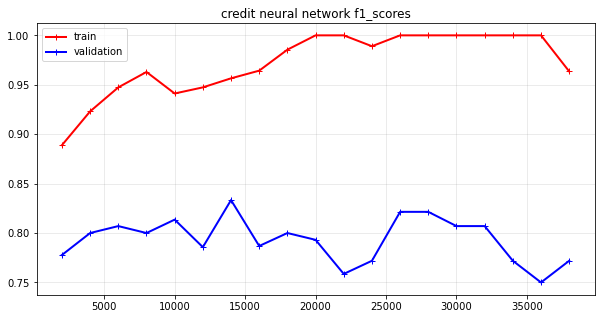

In [22]:
plot_learning_curve(train_credit_mlp_metric, val_credit_mlp_metric, indices_credit_mlp, title="credit neural network f1_scores")

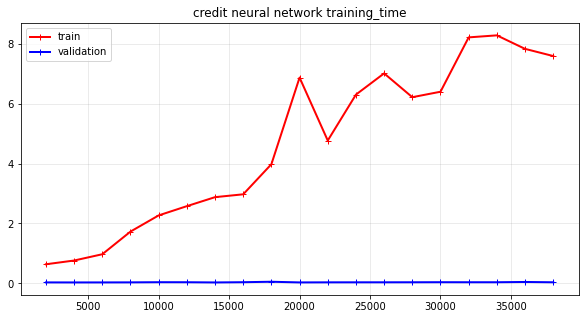

In [23]:
plot_learning_curve(training_credit_mlp_time, testing_credit_mlp_time, indices_credit_mlp, title="credit neural network training_time")

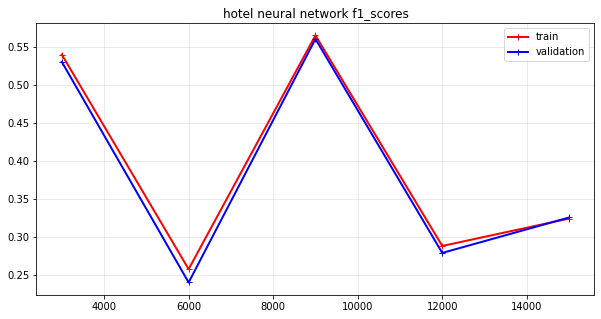

In [97]:
plot_learning_curve(train_hotel_mlp_metric, val_hotel_mlp_metric, indices_hotel_mlp, title="hotel neural network f1_scores")

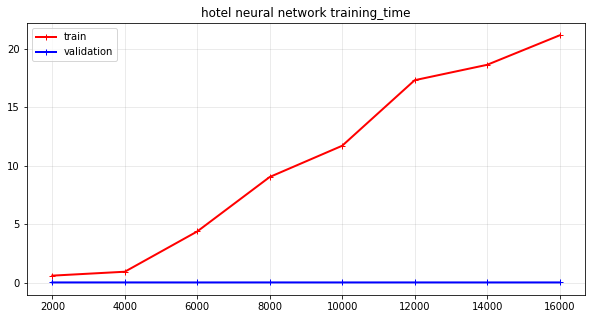

In [91]:
plot_learning_curve(training_hotel_mlp_time, testing_hotel_mlp_time, indices_hotel_mlp, title="hotel neural network training_time")

## 2.3 Gradient Boosting Tree

In [102]:
def gbt_model_complexity (X_train, y_train, X_test, y_test, title):
    f1_score_test = []
    f1_score_train = []

    max_depth = list(range(1,31))
    for i in max_depth:
        gbt = GradientBoostingClassifier(max_depth=i, random_state=1, min_samples_leaf=1)
        gbt.fit(X_train, y_train)
        y_train_pred = gbt.predict(X_train)
        y_test_pred = gbt.predict(X_test)
        
        f1_score_train.append(f1_score(y_train, y_train_pred))
        f1_score_test.append(f1_score(y_test, y_test_pred))

    # print(f1_score_test)
    # print(f1_score_train)

    plt.plot(max_depth, f1_score_train, "r-+", linewidth=2, label='Training F1 score')
    plt.plot(max_depth, f1_score_test, "b-+", linewidth=2, label='Testing F1 score')
    plt.ylabel('Model F1 score')
    plt.xlabel('Max Tree depth')
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.title(title)
    plt.show()

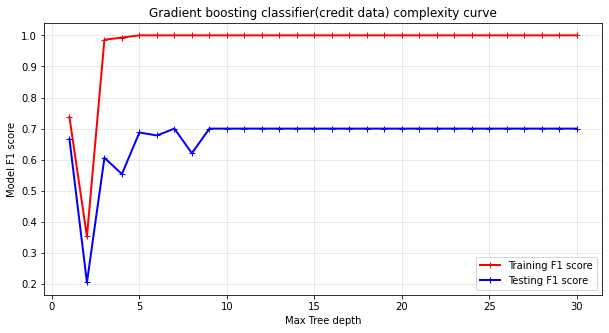

In [101]:
gbt_model_complexity(X_credit_train, y_credit_train, X_credit_test, y_credit_test,'Gradient boosting classifier(credit data) complexity curve')

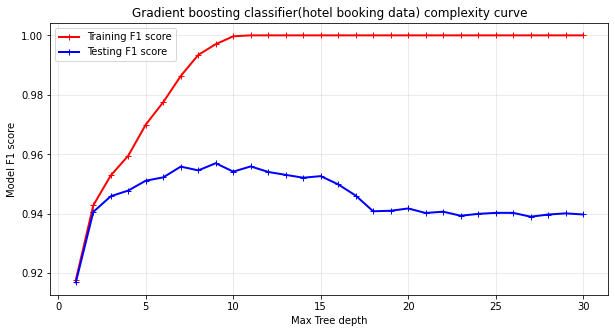

In [103]:
gbt_model_complexity(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test,'Gradient boosting classifier(hotel booking data) complexity curve')

In [31]:
%%time

param_grid = {
    'min_samples_leaf': [15, 25],
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100, 200],
}
search_credit_gbt = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_credit_gbt.fit(X_credit_train, y_credit_train)

y_credit_pred = search_credit_gbt.predict(X_credit_test)

accuracy_credit = accuracy_score(y_credit_test, y_credit_pred)
print("===========================================")
print("Classification Report for Credit Card Fraud")
print(accuracy_credit)
print(classification_report(y_credit_test, y_credit_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 26.9min finished
Classification Report for Credit Card Fraud
0.9980689332319036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.25      0.03      0.06        31

    accuracy                           1.00     17089
   macro avg       0.62      0.52      0.53     17089
weighted avg       1.00      1.00      1.00     17089

CPU times: user 52.8 s, sys: 623 ms, total: 53.4 s
Wall time: 27min 43s


In [28]:
%%time
search_hotel_gbt = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_hotel_gbt.fit(X_hotel_train, y_hotel_train)

y_hotel_pred = search_hotel_gbt.predict(X_hotel_test)

accuracy_hotel = accuracy_score(y_hotel_test, y_hotel_pred)
print("===========================================")
print("Classification Report for Hotel Booking Cancellation")
print(accuracy_hotel)
print(classification_report(y_hotel_test, y_hotel_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.3min finished
Classification Report for Hotel Booking  Cancellation
0.966499162479062
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4469
           1       0.96      0.95      0.96      2695

    accuracy                           0.97      7164
   macro avg       0.97      0.96      0.96      7164
weighted avg       0.97      0.97      0.97      7164

CPU times: user 9.23 s, sys: 226 ms, total: 9.45 s
Wall time: 2min 28s


In [32]:
train_credit_gbt_metric, val_credit_gbt_metric, indices_credit_gbt, training_credit_gbt_time, testing_credit_gbt_time = learning_Curve(X_credit_train, y_credit_train, X_credit_test, y_credit_test, search_credit_gbt.best_estimator_, f1_score, step=2000)

training 2000 samples took 1.7881550788879395
training 4000 samples took 3.969602108001709
training 6000 samples took 5.5725789070129395
training 8000 samples took 7.729326009750366
training 10000 samples took 11.067409038543701
training 12000 samples took 13.639494180679321
training 14000 samples took 16.22581672668457
training 16000 samples took 18.887847185134888
training 18000 samples took 21.48398518562317
training 20000 samples took 24.153032779693604
training 22000 samples took 27.38611888885498
training 24000 samples took 30.174453020095825
training 26000 samples took 33.90375804901123
training 28000 samples took 35.56072998046875
training 30000 samples took 39.09528183937073
training 32000 samples took 40.32096481323242
training 34000 samples took 44.45828580856323
training 36000 samples took 45.638816833496094
training 38000 samples took 52.188518047332764


In [33]:
train_hotel_gbt_metric, val_hotel_gbt_metric, indices_hotel_gbt, training_hotel_gbt_time, testing_hotel_gbt_time = learning_Curve(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, search_hotel_gbt.best_estimator_, f1_score, step=2000)


training 2000 samples took 0.9198520183563232
training 4000 samples took 1.7606070041656494
training 6000 samples took 2.8092541694641113
training 8000 samples took 3.611984968185425
training 10000 samples took 4.416831016540527
training 12000 samples took 5.258390188217163
training 14000 samples took 6.171039819717407
training 16000 samples took 7.098698377609253


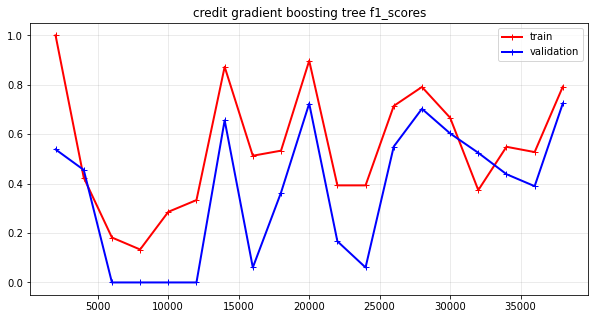

In [34]:
plot_learning_curve(train_credit_gbt_metric, val_credit_gbt_metric, indices_credit_gbt, title="credit gradient boosting tree f1_scores")

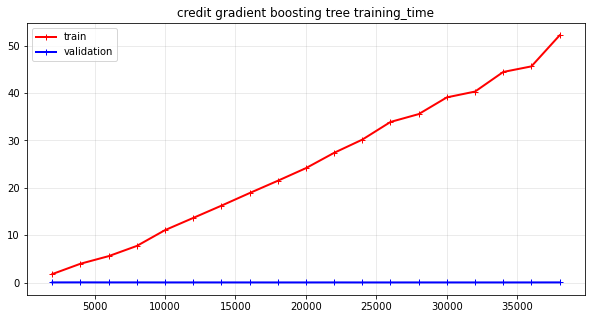

In [35]:
plot_learning_curve(training_credit_gbt_time, testing_credit_gbt_time, indices_credit_gbt, title="credit gradient boosting tree training_time")

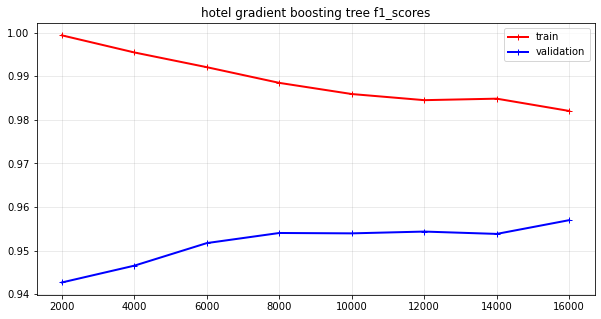

In [36]:
plot_learning_curve(train_hotel_gbt_metric, val_hotel_gbt_metric, indices_hotel_gbt, title="hotel gradient boosting tree f1_scores")

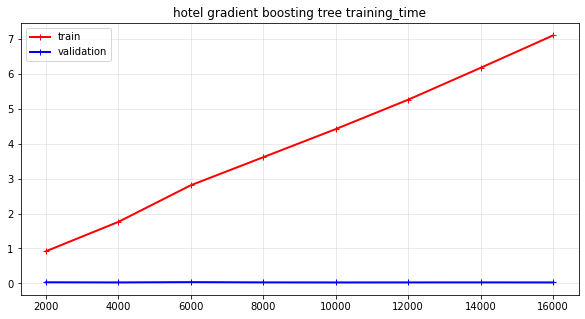

In [37]:
plot_learning_curve(training_hotel_gbt_time, testing_hotel_gbt_time, indices_hotel_gbt, title="hotel gradient boosting tree training_time")

## 2.4 Support Vector Machine

In [ ]:
# try two different kernels 

In [106]:
credit_svm_kernel_rbf = SVC(kernel='rbf')
credit_svm_kernel_rbf.fit(X_credit_train, y_credit_train)
y_credit_pred_kernel_rbf = credit_svm_kernel_rbf.predict(X_credit_test)
accuracy_credit_kernel_rbf = accuracy_score(y_credit_test, y_credit_pred_kernel_rbf)
print(accuracy_credit_kernel_rbf)
print(classification_report(y_credit_test, y_credit_pred_kernel_rbf))

0.998829656504184
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.82      0.45      0.58        31

    accuracy                           1.00     17089
   macro avg       0.91      0.73      0.79     17089
weighted avg       1.00      1.00      1.00     17089



In [105]:
accuracy_credit_kernel_rbf

0.998829656504184

In [107]:
credit_svm_kernel_l = SVC(kernel='linear')
credit_svm_kernel_l.fit(X_credit_train, y_credit_train)
y_credit_pred_kernel_l = credit_svm_kernel_l.predict(X_credit_test)
accuracy_credit_kernel_l = accuracy_score(y_credit_test, y_credit_pred_kernel_l)
print(classification_report(y_credit_test, y_credit_pred_kernel_l))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.82      0.74      0.78        31

    accuracy                           1.00     17089
   macro avg       0.91      0.87      0.89     17089
weighted avg       1.00      1.00      1.00     17089



In [109]:
#hotel data rbf kernel 

hotel_svm_kernel_rbf = SVC(kernel='rbf')
hotel_svm_kernel_rbf.fit(X_hotel_train, y_hotel_train)
y_hotel_pred_kernel_rbf = hotel_svm_kernel_rbf.predict(X_hotel_test)
accuracy_hotel_kernel_rbf = accuracy_score(y_hotel_test, y_hotel_pred_kernel_rbf)
print(accuracy_hotel_kernel_rbf)
print(classification_report(y_hotel_test, y_hotel_pred_kernel_rbf))

0.862786152987158
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4469
           1       0.82      0.82      0.82      2695

    accuracy                           0.86      7164
   macro avg       0.85      0.85      0.85      7164
weighted avg       0.86      0.86      0.86      7164



In [23]:
#hotel data linear kernel 

from sklearn.svm import LinearSVC

# similar to SVC(kernal='linear') but faster
hotel_svm_kernel_l = LinearSVC(max_iter=20000, C=0.0001, dual=True) # , penalty="l1"
hotel_svm_kernel_l.fit(X_hotel_train, y_hotel_train)
y_hotel_pred_kernel_l = hotel_svm_kernel_l.predict(X_hotel_test)
accuracy_hotel_kernel_l = accuracy_score(y_hotel_test, y_hotel_pred_kernel_l)
print(accuracy_hotel_kernel_l)
print(classification_report(y_hotel_test, y_hotel_pred_kernel_l))

/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6115298715801228
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      4469
           1       0.49      0.67      0.56      2695

    accuracy                           0.61      7164
   macro avg       0.61      0.62      0.61      7164
weighted avg       0.65      0.61      0.62      7164



/Users/annieyuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [ ]:
%%time

param_grid = {
    'C': [1e-3, 1e-2, 1e-1, 1],
    'kernel': ['rbf', 'linear'],
}
search_credit_svm = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_credit_svm.fit(X_credit_train, y_credit_train)

y_credit_pred = search_credit_svm.predict(X_credit_test)

accuracy_credit = accuracy_score(y_credit_test, y_credit_pred)
print("===========================================")
print("Classification Report for Credit Card Fraud")
print(accuracy_credit)
print(classification_report(y_credit_test, y_credit_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.3s finished
Classification Report for Credit Card Fraud
0.9992392767277196
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.85      0.71      0.77        31

    accuracy                           1.00     17089
   macro avg       0.92      0.85      0.89     17089
weighted avg       1.00      1.00      1.00     17089

CPU times: user 2.07 s, sys: 224 ms, total: 2.3 s
Wall time: 47.8 s


In [ ]:
%%time
# search_hotel_svm = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=3)
# did not use gridsearch, it take too long to train the SVC model
search_hotel_svm = SVC()
search_hotel_svm.fit(X_hotel_train, y_hotel_train)

y_hotel_pred = search_hotel_svm.predict(X_hotel_test)

accuracy_hotel = accuracy_score(y_hotel_test, y_hotel_pred)
print("===========================================")
print("Classification Report for Hotel Booking Cancellation")
print(accuracy_hotel)
print(classification_report(y_hotel_test, y_hotel_pred))

Classification Report for Hotel Booking Cancellation
0.862786152987158
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4469
           1       0.82      0.82      0.82      2695

    accuracy                           0.86      7164
   macro avg       0.85      0.85      0.85      7164
weighted avg       0.86      0.86      0.86      7164

CPU times: user 10.5 s, sys: 352 ms, total: 10.8 s
Wall time: 11 s


In [ ]:
train_credit_svm_metric, val_credit_svm_metric, indices_credit_svm, training_credit_svm_time, testing_credit_svm_time = learning_Curve(X_credit_train, y_credit_train, X_credit_test, y_credit_test, search_credit_svm.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.011595010757446289
training 4000 samples took 0.008409976959228516
training 6000 samples took 0.012840986251831055
training 8000 samples took 0.020409822463989258
training 10000 samples took 0.0356748104095459
training 12000 samples took 0.03784012794494629
training 14000 samples took 0.08808088302612305
training 16000 samples took 0.0631871223449707
training 18000 samples took 0.0857846736907959
training 20000 samples took 0.08876895904541016
training 22000 samples took 0.1153559684753418
training 24000 samples took 0.1250767707824707
training 26000 samples took 0.22092175483703613
training 28000 samples took 0.17519927024841309
training 30000 samples took 0.18385887145996094
training 32000 samples took 0.2345726490020752
training 34000 samples took 0.25368213653564453
training 36000 samples took 0.25931715965270996
training 38000 samples took 0.3074839115142822


In [ ]:
train_hotel_svm_metric, val_hotel_svm_metric, indices_hotel_svm, training_hotel_svm_time, testing_hotel_svm_time = learning_Curve(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, search_hotel_svm, f1_score, step=2000)

training 2000 samples took 0.14658117294311523
training 4000 samples took 0.44479799270629883
training 6000 samples took 0.9322490692138672
training 8000 samples took 1.7940280437469482
training 10000 samples took 3.829240083694458
training 12000 samples took 5.741214990615845
training 14000 samples took 5.490042686462402
training 16000 samples took 7.01732611656189


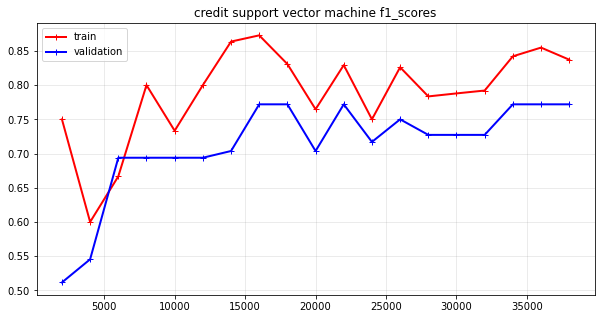

In [ ]:
plot_learning_curve(train_credit_svm_metric, val_credit_svm_metric, indices_credit_svm, title="credit support vector machine f1_scores")

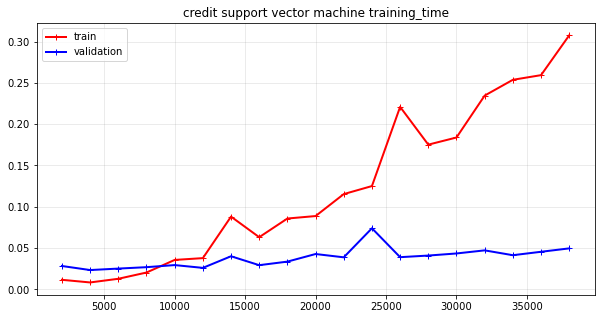

In [ ]:
plot_learning_curve(training_credit_svm_time, testing_credit_svm_time, indices_credit_svm, title="credit support vector machine training_time")

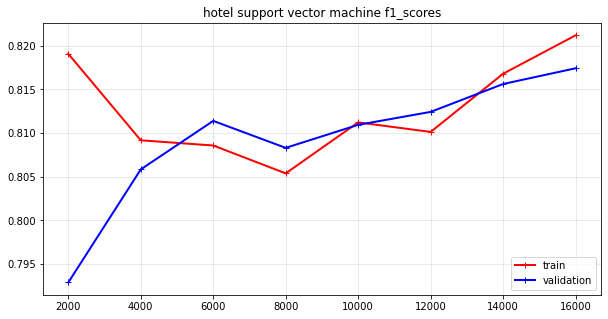

In [ ]:
plot_learning_curve(train_hotel_svm_metric, val_hotel_svm_metric, indices_hotel_svm, title="hotel support vector machine f1_scores")

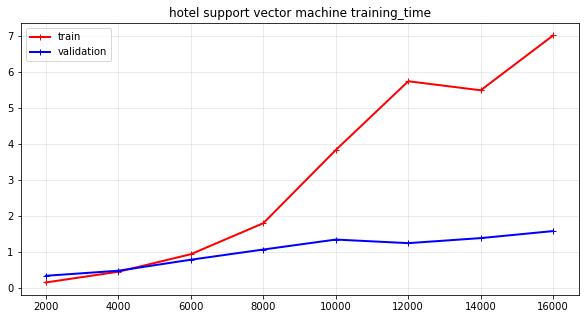

In [ ]:
plot_learning_curve(training_hotel_svm_time, testing_hotel_svm_time, indices_hotel_svm, title="hotel support vector machine training_time")

## 2.5 K Nearest Neighbor

In [29]:
def knn_model_complexity (X_train, y_train, X_test, y_test, title):
    f1_score_test = []
    f1_score_train = []

    k_range = list(range(1,50,2))

    for i in k_range:
        knn_classifier = KNeighborsClassifier(n_neighbors=i)
        #search_credit_knn.fit(X_credit_train, y_credit_train)
        #dtc = GradientBoostingClassifier(max_depth=i, random_state=1, min_samples_leaf=1)
        knn_classifier.fit(X_train, y_train)
        y_train_pred = knn_classifier.predict(X_train)
        y_test_pred = knn_classifier.predict(X_test)
        
        f1_score_train.append(f1_score(y_train, y_train_pred))
        f1_score_test.append(f1_score(y_test, y_test_pred))

    # print(f1_score_test)
    # print(f1_score_train)

    plt.plot(k_range, f1_score_train, "r-+", linewidth=2, label='Training F1 score')
    plt.plot(k_range, f1_score_test, "b-+", linewidth=2, label='Testing F1 score')
    plt.ylabel('Model F1 score')
    plt.xlabel('neighbor number')
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.title(title)
    plt.show()

<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y

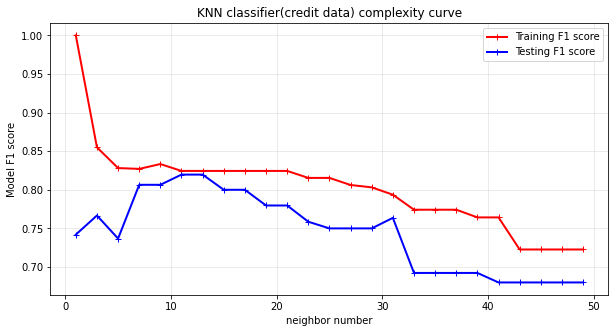

In [30]:
knn_model_complexity (X_credit_train, y_credit_train, X_credit_test, y_credit_test, 'KNN classifier(credit data) complexity curve')


<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_classifier.fit(X_train, y_train)
<ipython-input-29-ad77d912d70a>:11: DataConversionWarning: A column-vector y

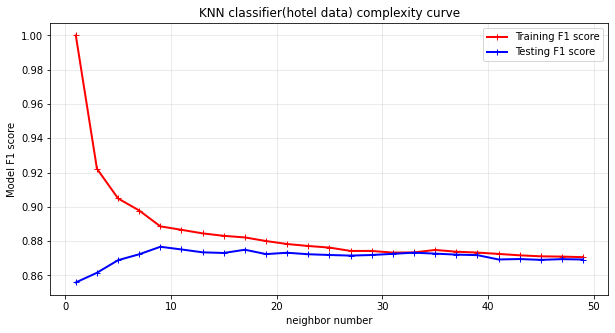

In [31]:
knn_model_complexity (X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, 'KNN classifier(hotel data) complexity curve')


In [ ]:
%%time

param_grid = {
    'n_neighbors': [10, 50, 80, 100],
}

search_credit_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_credit_knn.fit(X_credit_train, y_credit_train)

y_credit_pred = search_credit_svm.predict(X_credit_test)

accuracy_credit = accuracy_score(y_credit_test, y_credit_pred)
print("===========================================")
print("Classification Report for Credit Card Fraud")
print(accuracy_credit)
print(classification_report(y_credit_test, y_credit_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  1.2min remaining:   49.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished
Classification Report for Credit Card Fraud
0.9992392767277196
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17058
           1       0.85      0.71      0.77        31

    accuracy                           1.00     17089
   macro avg       0.92      0.85      0.89     17089
weighted avg       1.00      1.00      1.00     17089

CPU times: user 760 ms, sys: 171 ms, total: 931 ms
Wall time: 1min 50s


In [ ]:
%%time
search_hotel_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)
search_hotel_knn.fit(X_hotel_train, y_hotel_train)

y_hotel_pred = search_hotel_knn.predict(X_hotel_test)

accuracy_hotel = accuracy_score(y_hotel_test, y_hotel_pred)
print("===========================================")
print("Classification Report for Hotel Booking Cancellation")
print(accuracy_hotel)
print(classification_report(y_hotel_test, y_hotel_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    6.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.8s finished
Classification Report for Hotel Booking Cancellation
0.902428810720268
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4469
           1       0.88      0.85      0.87      2695

    accuracy                           0.90      7164
   macro avg       0.90      0.89      0.90      7164
weighted avg       0.90      0.90      0.90      7164

CPU times: user 825 ms, sys: 136 ms, total: 961 ms
Wall time: 7.35 s


In [ ]:
train_credit_knn_metric, val_credit_knn_metric, indices_credit_knn, training_credit_knn_time, testing_credit_knn_time = learning_Curve(X_credit_train, y_credit_train, X_credit_test, y_credit_test, search_credit_knn.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.011122941970825195
training 4000 samples took 0.007335186004638672
training 6000 samples took 0.013469934463500977
training 8000 samples took 0.016683101654052734
training 10000 samples took 0.021103858947753906
training 12000 samples took 0.02126598358154297
training 14000 samples took 0.027652978897094727
training 16000 samples took 0.033083200454711914
training 18000 samples took 0.0438840389251709
training 20000 samples took 0.04456496238708496
training 22000 samples took 0.06936883926391602
training 24000 samples took 0.05315709114074707
training 26000 samples took 0.05776691436767578
training 28000 samples took 0.08316493034362793
training 30000 samples took 0.0728609561920166
training 32000 samples took 0.08464312553405762
training 34000 samples took 0.11560201644897461
training 36000 samples took 0.09472513198852539
training 38000 samples took 0.10813403129577637


In [ ]:
train_hotel_knn_metric, val_hotel_knn_metric, indices_hotel_knn, training_hotel_knn_time, testing_hotel_knn_time = learning_Curve(X_hotel_train, y_hotel_train, X_hotel_test, y_hotel_test, search_hotel_knn.best_estimator_, f1_score, step=2000)

training 2000 samples took 0.010265111923217773
training 4000 samples took 0.0078051090240478516
training 6000 samples took 0.009918928146362305
training 8000 samples took 0.01491403579711914
training 10000 samples took 0.018594026565551758
training 12000 samples took 0.02184915542602539
training 14000 samples took 0.02551102638244629
training 16000 samples took 0.03236079216003418


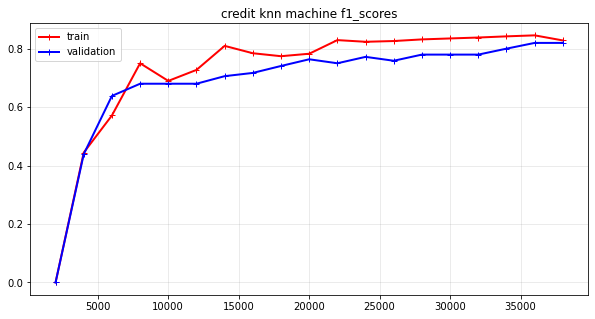

In [ ]:
plot_learning_curve(train_credit_knn_metric, val_credit_knn_metric, indices_credit_knn, title="credit knn machine f1_scores")

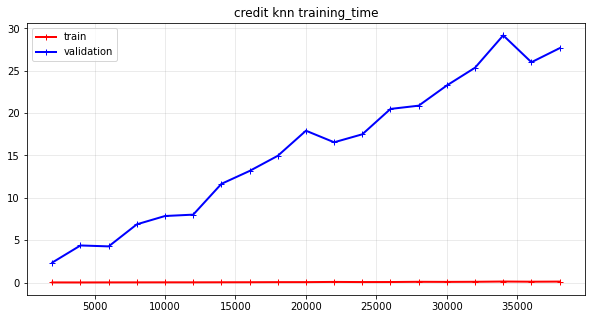

In [ ]:
plot_learning_curve(training_credit_knn_time, testing_credit_knn_time, indices_credit_knn, title="credit knn training_time")

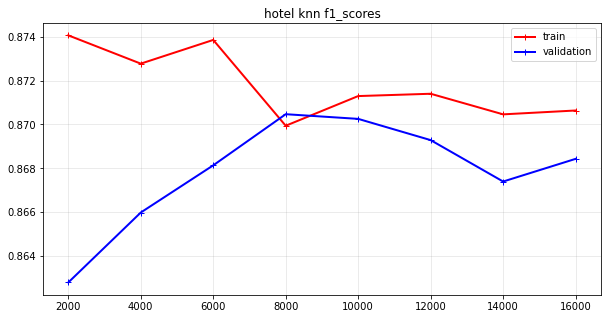

In [ ]:
plot_learning_curve(train_hotel_knn_metric, val_hotel_knn_metric, indices_hotel_knn, title="hotel knn f1_scores")

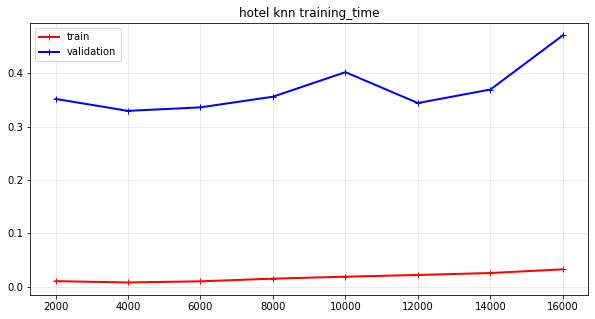

In [ ]:
plot_learning_curve(training_hotel_knn_time, testing_hotel_knn_time, indices_hotel_knn, title="hotel knn training_time")

# 3. Results

In [ ]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()

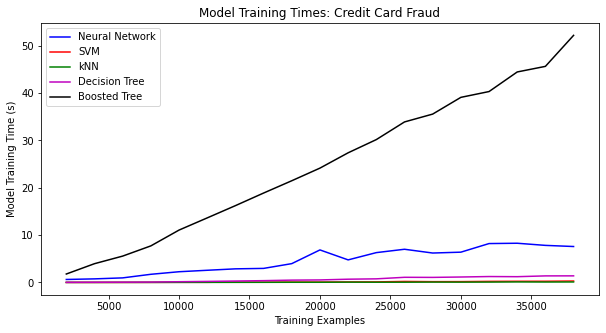

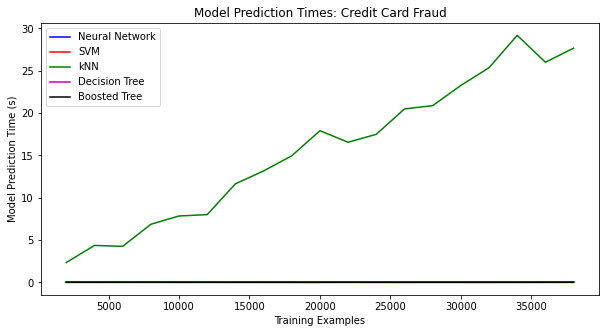

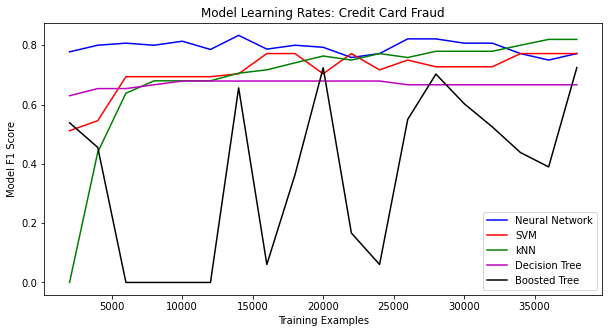

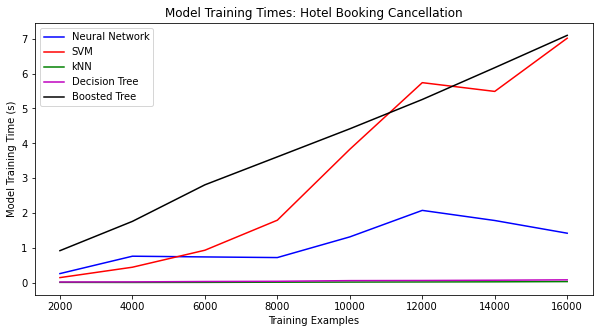

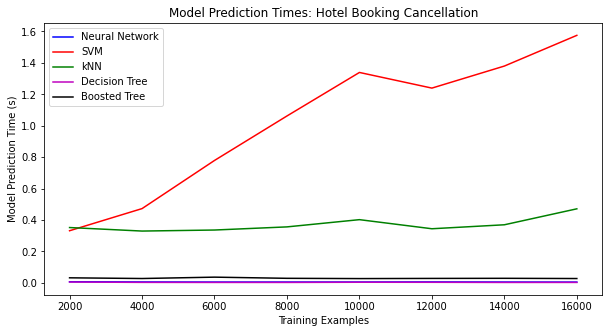

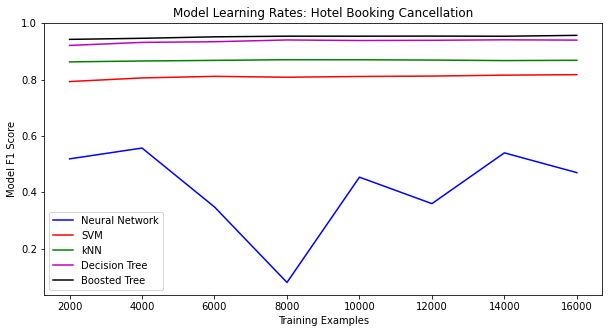

In [ ]:
compare_fit_time(indices_credit_knn, training_credit_mlp_time, training_credit_svm_time, training_credit_knn_time, 
                 training_credit_dt_time, training_credit_gbt_time, 'Credit Card Fraud')                       
compare_pred_time(indices_credit_knn, testing_credit_mlp_time, testing_credit_svm_time, testing_credit_knn_time, 
                 testing_credit_dt_time, testing_credit_gbt_time, 'Credit Card Fraud')   
compare_learn_time(indices_credit_knn, val_credit_mlp_metric, val_credit_svm_metric, val_credit_knn_metric, 
                 val_credit_dt_metric, val_credit_gbt_metric, 'Credit Card Fraud')  



compare_fit_time(indices_hotel_knn, training_hotel_mlp_time, training_hotel_svm_time, training_hotel_knn_time, 
                 training_hotel_dt_time, training_hotel_gbt_time, 'Hotel Booking Cancellation')       
compare_pred_time(indices_hotel_knn, testing_hotel_mlp_time, testing_hotel_svm_time, testing_hotel_knn_time, 
                 testing_hotel_dt_time, testing_hotel_gbt_time, 'Hotel Booking Cancellation')           
compare_learn_time(indices_hotel_knn, val_hotel_mlp_metric, val_hotel_svm_metric, val_hotel_knn_metric, 
                 val_hotel_dt_metric, val_hotel_gbt_metric, 'Hotel Booking Cancellation')